### CRF

In [1]:
!pip install datasets
!pip install pytorch-crf
!pip install seaborn
from IPython.display import clear_output
clear_output()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchcrf import CRF
import numpy as np
from datasets import load_dataset
import time
from torch.utils.data import DataLoader, TensorDataset
ds = load_dataset("DFKI-SLT/few-nerd", "supervised")

data = ds['train'][:int(1 * len(ds["train"]))]
test_dataset = ds['test'][:int(1 * len(ds["test"]))]

def generate_features(token):
    features = []
    features.append("UPPER" if token.isupper() else "non-upper")
    features.append("DIGIT" if token.isdigit() else "non-digit")
    features.append("TITLE" if token.istitle() else "non-title")
    return features

X_train = []
y_train = []

for sentence, ner_tags in zip(data['tokens'], data['fine_ner_tags']):
    sentence_features = []
    sentence_labels = []
    for token, tag in zip(sentence, ner_tags):
        features = generate_features(token)  # You can add more features here if necessary
        sentence_features.append(features)
        sentence_labels.append(tag)  # Store the tag for this token
    X_train.append(sentence_features)
    y_train.append(sentence_labels)

word_vocab = {'<PAD>': 0} 
for sentence in data['tokens']:
    for token in sentence:
        if token not in word_vocab:
            word_vocab[token] = len(word_vocab)

tag_vocab = {0: 0}
for tag_list in data['fine_ner_tags']:
    for tag in tag_list:
        tag_name = tag if tag != 0 else 0
        if tag_name not in tag_vocab:
            tag_vocab[tag_name] = len(tag_vocab)

def convert_features_to_indices(X_train, word_vocab):
    X_train_indices = []
    for sentence_features in X_train:
        sentence_indices = []
        for features in sentence_features:
            feature_indices = [word_vocab.get(f, word_vocab["<PAD>"]) for f in features]
            sentence_indices.append(feature_indices)
        X_train_indices.append(sentence_indices)
    return X_train_indices

def convert_labels_to_indices(y_train, tag_vocab):
    y_train_indices = []
    for sentence_labels in y_train:
        sentence_indices = [tag_vocab.get(tag, tag_vocab[0]) for tag in sentence_labels]
        y_train_indices.append(sentence_indices)
    return y_train_indices

X_train_indices = convert_features_to_indices(X_train, word_vocab)
y_train_indices = convert_labels_to_indices(y_train, tag_vocab)

# print("Word Vocabulary:", word_vocab)
# print("Tag Vocabulary:", tag_vocab)
# print("X_train (features):", X_train_indices)
# print("y_train (labels):", y_train_indices)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchcrf import CRF
import time

class Linear_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128):
        super(Linear_CRF, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.hidden2tag = nn.Linear(embedding_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, sentences, tags=None):
        embeddings = self.word_embeddings(sentences)
        emissions = self.hidden2tag(embeddings)
        if tags is not None:
            return -self.crf(emissions, tags)  # Negative log-likelihood loss
        else:
            return self.crf.decode(emissions)  # Decoding (inference)

def convert_words_to_indices(sentence, word_vocab):
    return [word_vocab.get(word, word_vocab["<PAD>"]) for word in sentence]

def convert_tags_to_indices(tags, tag_vocab):
    return [tag_vocab.get(tag, tag_vocab[0]) for tag in tags]

def pad_sequences(sequences, pad_value=0):
    max_len = max(len(seq) for seq in sequences)
    return [seq + [pad_value] * (max_len - len(seq)) for seq in sequences]

# Prepare data
X_train_indices = [convert_words_to_indices(sentence, word_vocab) for sentence in data['tokens']]
y_train_indices = [convert_tags_to_indices(tags, tag_vocab) for tags in data['fine_ner_tags']]

X_train_indices = pad_sequences(X_train_indices, pad_value=word_vocab["<PAD>"])
y_train_indices = pad_sequences(y_train_indices, pad_value=tag_vocab[0])

X_train_tensor = torch.tensor(X_train_indices, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)

batch_size = 1024
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model
model = Linear_CRF(len(word_vocab), len(tag_vocab))

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decay learning rate every 5 epochs

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    total_samples = 0

    for batch_idx, (sentences, tags) in enumerate(train_loader):
        optimizer.zero_grad()
        loss = model(sentences, tags)
        loss.backward()
        
        # Gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item()
        total_samples += sentences.size(0)

    scheduler.step()  # Update the learning rate
    training_time = time.time() - start_time  # Time taken for the epoch
    avg_loss = running_loss / len(train_loader)  # Average loss per batch

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Time: {training_time:.2f}s")

# Save the model after training
torch.save(model.state_dict(), 'linear_crf_model10.pth')

# Evaluation
model.eval()

/home/142402022/.local/lib/python3.9/site-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:530.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Epoch 1/10, Loss: 143162.4390, Time: 1062.98s
Epoch 2/10, Loss: 27352.9645, Time: 1068.77s
Epoch 3/10, Loss: 19504.0781, Time: 1237.87s
Epoch 4/10, Loss: 16498.1573, Time: 1055.23s
Epoch 5/10, Loss: 14460.9691, Time: 1050.41s
Epoch 6/10, Loss: 13325.6590, Time: 1038.72s
Epoch 7/10, Loss: 13147.8051, Time: 1017.67s
Epoch 8/10, Loss: 13005.8260, Time: 1023.75s
Epoch 9/10, Loss: 12841.0764, Time: 1014.30s
Epoch 10/10, Loss: 12615.1915, Time: 1031.44s


Linear_CRF(
  (word_embeddings): Embedding(171196, 128)
  (hidden2tag): Linear(in_features=128, out_features=67, bias=True)
  (crf): CRF(num_tags=67)
)

/home/142402022/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/142402022/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/142402022/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


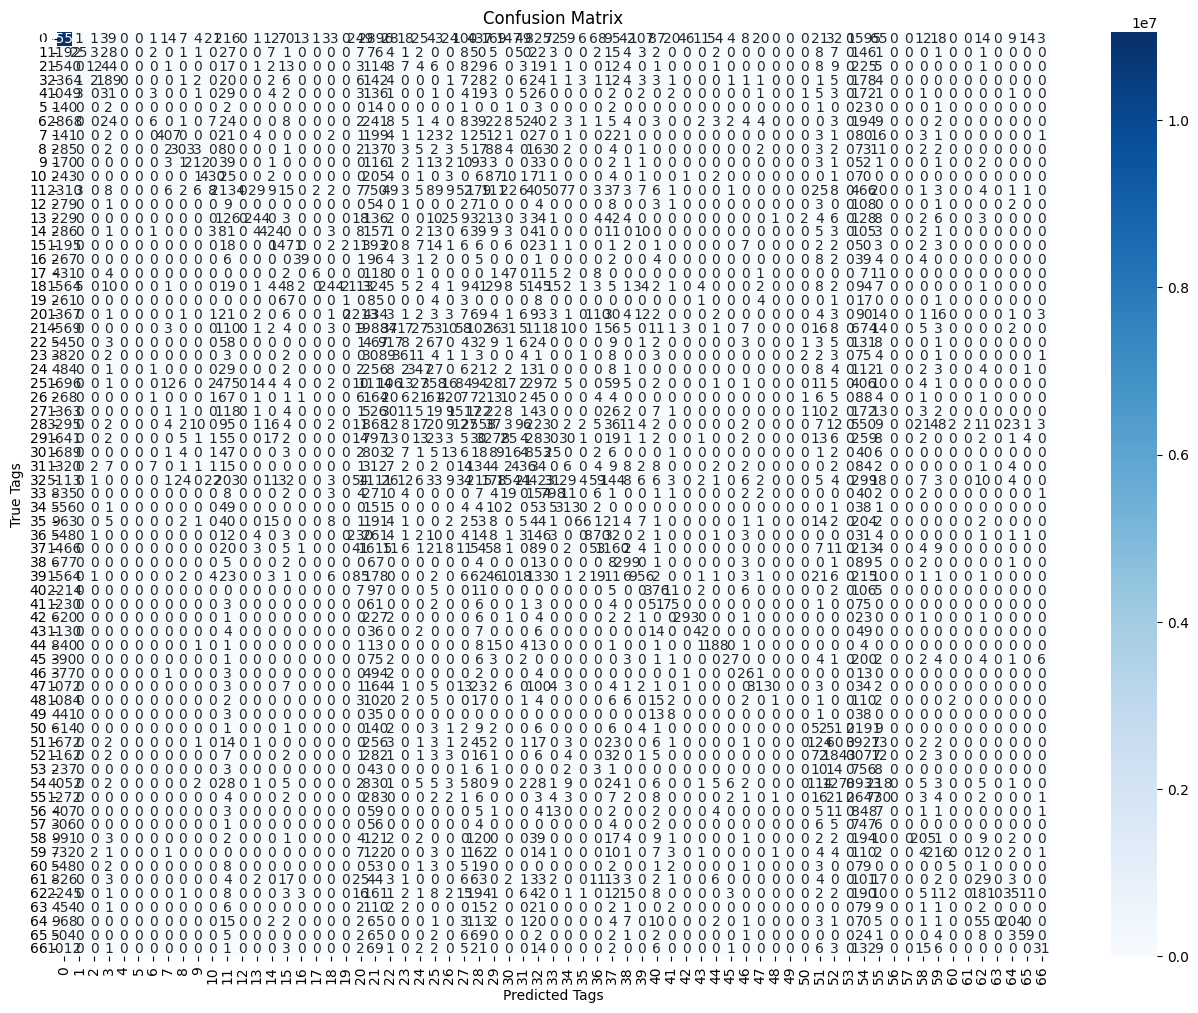


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00  11063617
           1       0.66      0.01      0.03      1707
           2       0.48      0.01      0.01      2105
           3       0.44      0.06      0.11      3027
           4       0.00      0.00      0.00      1511
           5       0.00      0.00      0.00       190
           6       0.27      0.00      0.00      3610
           7       0.89      0.41      0.56      1003
           8       0.83      0.25      0.39      1207
           9       0.86      0.28      0.42       764
          10       0.86      0.37      0.51      1169
          11       0.48      0.31      0.38      6885
          12       0.00      0.00      0.00       547
          13       0.77      0.22      0.35      1095
          14       0.79      0.35      0.48      1222
          15       0.81      0.45      0.58      3258
          16       0.66      0.08      0.14       488
   

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def convert_words_to_indices(sentence, word_vocab):
    return [word_vocab.get(word, word_vocab["<PAD>"]) for word in sentence]

def convert_tags_to_indices(tags, tag_vocab):
    return [tag_vocab.get(tag, tag_vocab[0]) for tag in tags]

def pad_sequences(sequences, pad_value=0):
    max_len = max(len(seq) for seq in sequences)
    return [seq + [pad_value] * (max_len - len(seq)) for seq in sequences]

X_test_indices = [convert_words_to_indices(sentence, word_vocab) for sentence in test_dataset['tokens']]
y_test_indices = [convert_tags_to_indices(tags, tag_vocab) for tags in test_dataset['fine_ner_tags']]

X_test_indices = pad_sequences(X_test_indices, pad_value=word_vocab["<PAD>"])
y_test_indices = pad_sequences(y_test_indices, pad_value=tag_vocab[0])

X_test_tensor = torch.tensor(X_test_indices, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_indices, dtype=torch.long)

batch_size = 32 
test_dataset_tensor = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset_tensor, batch_size=batch_size, shuffle=False)

model.eval()

all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch_idx, (sentences, tags) in enumerate(test_loader):
        predictions = model(sentences) 

        for prediction, true_tag in zip(predictions, tags):
            all_predictions.extend(prediction) 
            all_true_labels.extend(true_tag) 

predicted_tags = [list(tag_vocab.keys())[tag] for tag in all_predictions]
true_tags = [list(tag_vocab.keys())[tag] for tag in all_true_labels]

conf_matrix = confusion_matrix(true_tags, predicted_tags)

class_report = classification_report(true_tags, predicted_tags)


plt.figure(figsize=(16, 12))  # Set the size of the figure
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(list(tag_vocab.keys())), yticklabels=sorted(list(tag_vocab.keys())))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Tags")
plt.ylabel("True Tags")
plt.xticks(rotation=90) 
plt.yticks(rotation=0)
plt.show()

print("\nClassification Report:")
print(class_report)


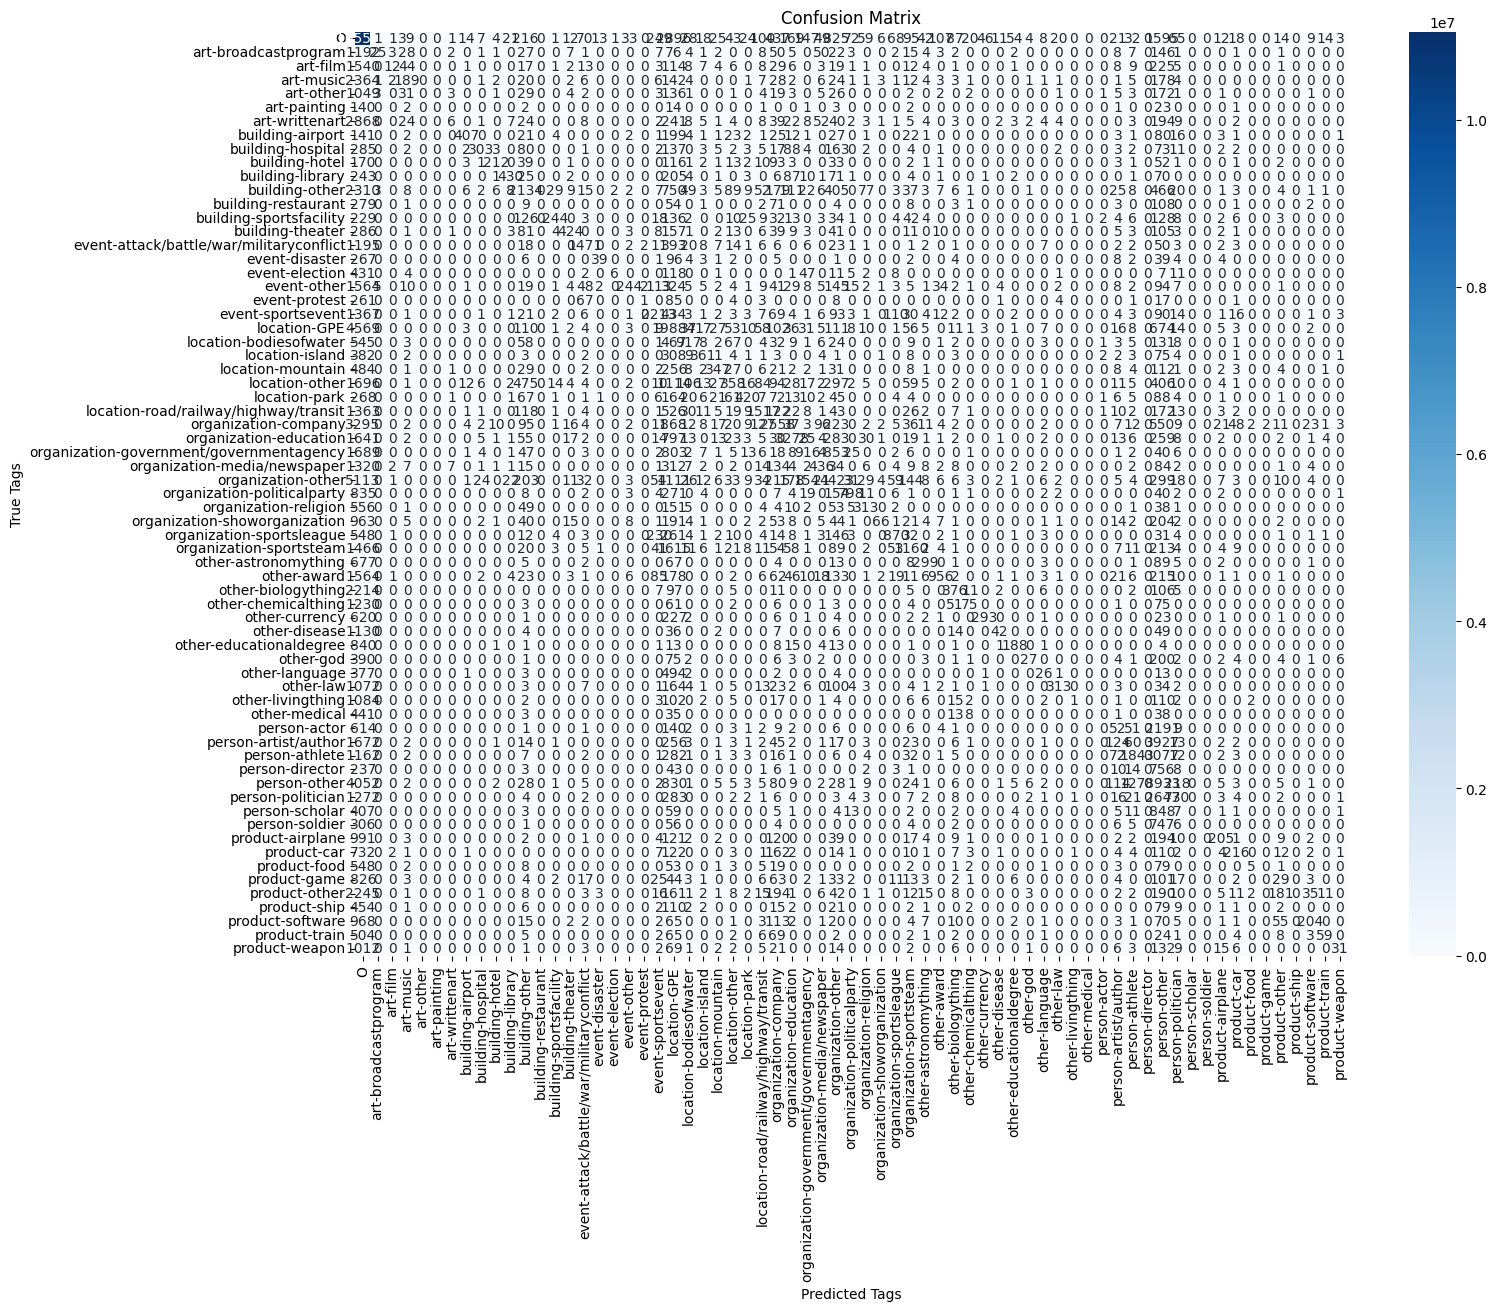

In [15]:
tag_labels = {
    0: "O",
    1: "art-broadcastprogram",
    2: "art-film",
    3: "art-music",
    4: "art-other",
    5: "art-painting",
    6: "art-writtenart",
    7: "building-airport",
    8: "building-hospital",
    9: "building-hotel",
    10: "building-library",
    11: "building-other",
    12: "building-restaurant",
    13: "building-sportsfacility",
    14: "building-theater",
    15: "event-attack/battle/war/militaryconflict",
    16: "event-disaster",
    17: "event-election",
    18: "event-other",
    19: "event-protest",
    20: "event-sportsevent",
    21: "location-GPE",
    22: "location-bodiesofwater",
    23: "location-island",
    24: "location-mountain",
    25: "location-other",
    26: "location-park",
    27: "location-road/railway/highway/transit",
    28: "organization-company",
    29: "organization-education",
    30: "organization-government/governmentagency",
    31: "organization-media/newspaper",
    32: "organization-other",
    33: "organization-politicalparty",
    34: "organization-religion",
    35: "organization-showorganization",
    36: "organization-sportsleague",
    37: "organization-sportsteam",
    38: "other-astronomything",
    39: "other-award",
    40: "other-biologything",
    41: "other-chemicalthing",
    42: "other-currency",
    43: "other-disease",
    44: "other-educationaldegree",
    45: "other-god",
    46: "other-language",
    47: "other-law",
    48: "other-livingthing",
    49: "other-medical",
    50: "person-actor",
    51: "person-artist/author",
    52: "person-athlete",
    53: "person-director",
    54: "person-other",
    55: "person-politician",
    56: "person-scholar",
    57: "person-soldier",
    58: "product-airplane",
    59: "product-car",
    60: "product-food",
    61: "product-game",
    62: "product-other",
    63: "product-ship",
    64: "product-software",
    65: "product-train",
    66: "product-weapon"
}

# Example confusion matrix (replace this with your actual `conf_matrix` data)
# Let's assume `conf_matrix` is a 67x67 matrix for demonstration purposes
# For your actual use case, replace this with the real confusion matrix
# Plotting the confusion matrix
plt.figure(figsize=(16, 12))  # Set the size of the figure
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[tag_labels[i] for i in range(len(tag_labels))], 
            yticklabels=[tag_labels[i] for i in range(len(tag_labels))])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Tags")
plt.ylabel("True Tags")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.yticks(rotation=0)   # Rotate y-axis labels for readability
plt.show()


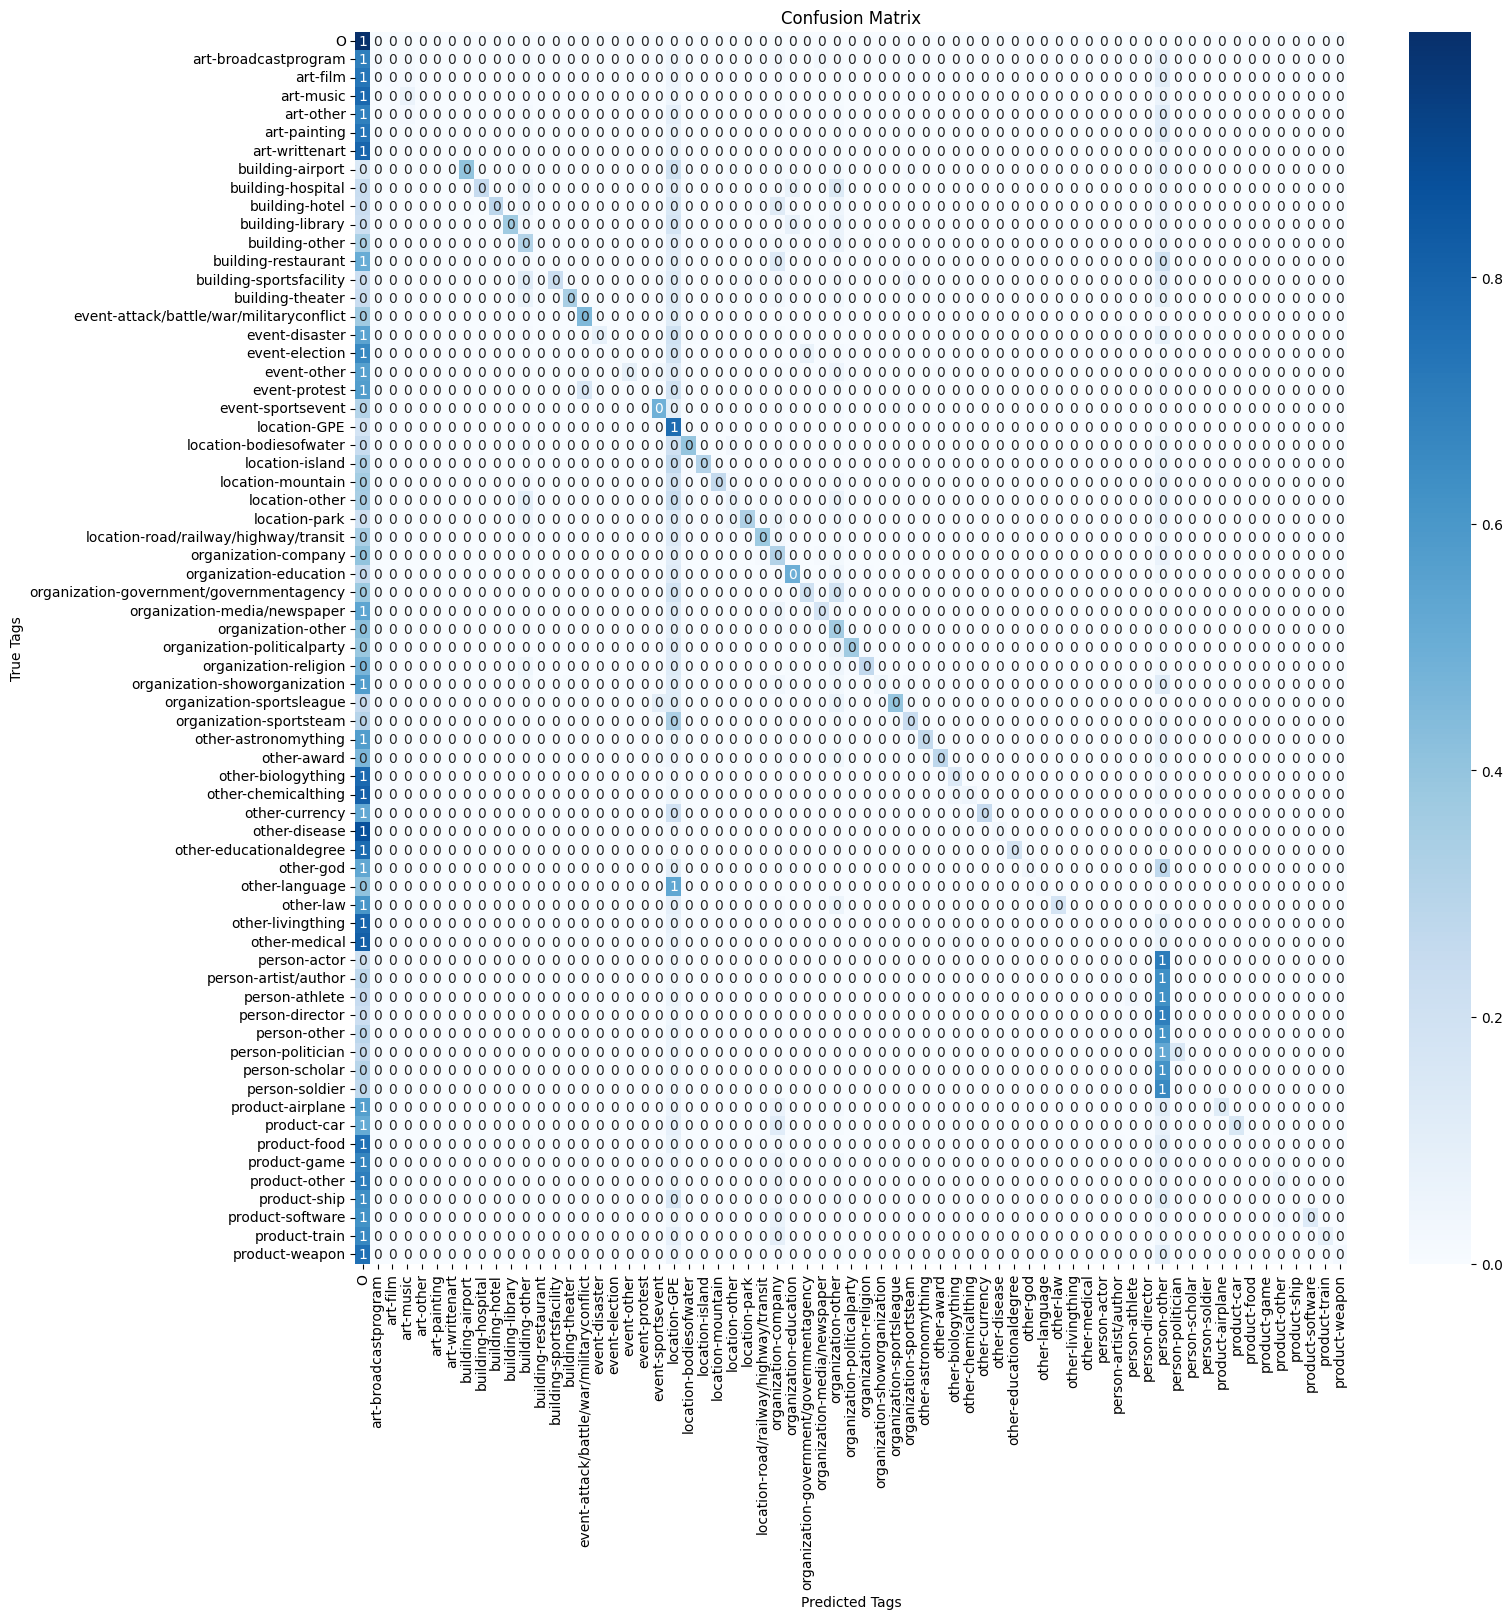

In [21]:
conf_matrix = confusion_matrix(true_tags, predicted_tags,normalize='true')
plt.figure(figsize=(16, 16))  # Set the size of the figure
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", 
            xticklabels=[tag_labels[i] for i in range(len(tag_labels))], 
            yticklabels=[tag_labels[i] for i in range(len(tag_labels))])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Tags")
plt.ylabel("True Tags")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.yticks(rotation=0)   # Rotate y-axis labels for readability
plt.show()